# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

***Цели исследования:***

1. Загрузить и подготовить данные.
2. Обучить разные модели. Для каждой осуществить подбор гиперпараметров.
3. Проанализировать скорость работы и качество моделей.

***Ход исследования***

Входные данные от заказчика — исторические данные о продаже автомобилей предоставлены в файле autos.csv. Перед обучением моделей необходимо провести предобработку данных. После подготовить данные для обучения и сравнить результаты моделей, время обучения и предсказания и порекомендовать лучшую.

## Подготовка данных

Импортируем библиотеки:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Загрузим данные:

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except Exception:
    data = pd.read_csv('autos.csv')
    
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Получим опиание:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

***Согласно описания данных***

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

Удалим из датасета признаки которые не оказывают влияния на результат предсказания модели.

In [4]:
data = data.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode'])

Просмотрев уникальные значения в каждом столбце, обнаруживаем в что в "NumberOfPictures" все значения пусты.

In [5]:
data['NumberOfPictures'].unique()

array([0])

Столбец не информативен, удаляем.

In [6]:
data = data.drop(columns=['NumberOfPictures'])

В данных есть пропуски. Для наглядности получим их процентные значения.

In [7]:
round(data.isna().mean() * 100, 1)

Price                0.0
VehicleType         10.6
RegistrationYear     0.0
Gearbox              5.6
Power                0.0
Model                5.6
Kilometer            0.0
FuelType             9.3
Brand                0.0
NotRepaired         20.1
dtype: float64

Все пропуски имеют категориальный тип данных, проще всего заменить их маркерованным значением "unknown".

In [8]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']] = data[['VehicleType',
                                                                         'Gearbox', 'Model',
                                                                         'FuelType', 'NotRepaired']].fillna('unknown')


Далее нам нужно удалить из датасета все строки с значением 'Brand != "sonstige_autos"'. Их присутсвие выхывает ошибку при обучении модели которую мы используем в конце раздела.

In [9]:
data = data.query('Brand != "sonstige_autos"')

Удаляем дубкаты.

In [10]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Проверим столбец "Model" на наличие неявных дубликатов. Получим список всех уникальных значений столбца.

In [11]:
data['Model'].unique()

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other',
       'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo',
       'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',

В столбце по разнаму записан один автомобиль 'rangerover' и 'range_rover'. Приведём всё к одному.

In [12]:
data.loc[(data['Model'] == 'rangerover'), 'Model'] = 'range_rover'

Получим описание данных.

In [13]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,306398.000000,306398.000000,306398.000000,306398.000000
mean,4477.283592,2004.217612,111.075878,127562.989967
std,4553.873535,82.917009,200.154918,38148.018780
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Столбцы "RegistrationYear" и "Power" содержат выбросы. Так же стоит обратить внимание на минимальные "нулевые" значения столбцов "Price" и "Power".

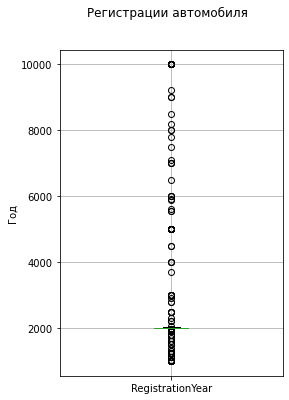

In [14]:
data.boxplot('RegistrationYear', figsize=(4,6))
plt.suptitle('Регистрации автомобиля')
plt.title(None)
plt.ylabel('Год')
plt.show()

Отсортируем выбросы из данных. Для этого сделаем срез с 1986 по 2019 год.

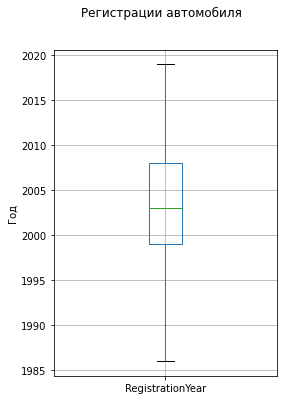

In [15]:
data = data.query('RegistrationYear >= 1986 & RegistrationYear <= 2019')

data.boxplot('RegistrationYear', figsize=(4,6))
plt.suptitle('Регистрации автомобиля')
plt.title(None)
plt.ylabel('Год')
plt.show()

Рассмотрим распределение цены в объявлениях.

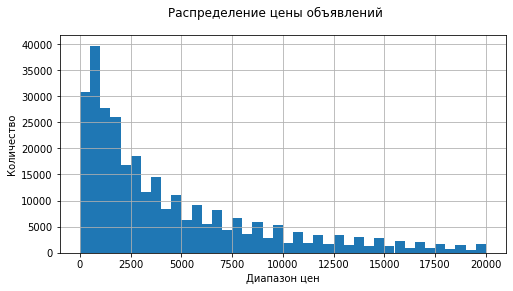

In [16]:
data.hist('Price', figsize=(8,4), bins=40)
plt.suptitle('Распределение цены объявлений')
plt.title(None)
plt.xlabel('Диапазон цен')
plt.ylabel('Количество')
plt.show()

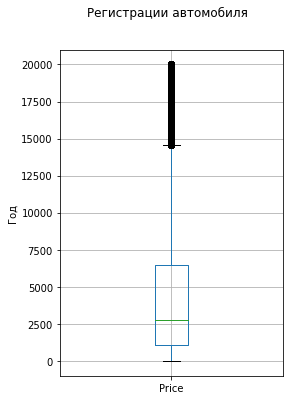

In [17]:
data.boxplot('Price', figsize=(4,6))
plt.suptitle('Регистрации автомобиля')
plt.title(None)
plt.ylabel('Год')
plt.show()

Помимо большого количества нулевых значений, в столбце так же присутствуют выбросы. Можно предположить что ноль в цене может быть следсвием "договорной цены" или отдачи автомобиля на металолом, для нас остаётся однозначным только то, что значение нулевое и его придётся отбросить. Теперь нужно определиться с диапазоном. Минимум упирается в ноль, т.к данные сильно смещены влево (тяготеет медиана и среднее), поэтому делать срез по превому квартили не получится. Не приходит идеи лучше как подобрать порог интуитивно. Определим порог нижнего среза равным 200.

In [18]:
data = data.query('Price >= 200')

Рассмотрим диаграмму размаха для значений столбца "Power".

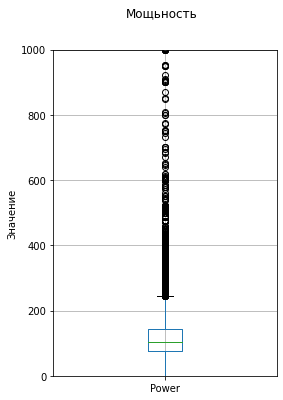

In [19]:
data.boxplot('Power', figsize=(4,6))
plt.suptitle('Мощьность')
plt.title(None)
plt.ylabel('Значение')
plt.ylim(0, 1000)
plt.show()

Верхний квартиль равен 143. Согласно описанию данные даны в лошадинных силах. Двигатели мощбностью более 500 л.с. в основном устанавливаются на тяжёлую спецтехнику. Выберем порог среза в районе 250.

In [20]:
data = data.query('Power <= 250')

Данные с мощьностью двигателя равной нулю могут говорить о том что автомобиль продаётся без двигателя. 

Взяв размер изначального датасета определим процент потерянных данных.

In [21]:
round(100 - data.shape[0] / 354369 * 100, 1)

20.7

Посмотрим как числовые признаки корелируют между собой.

In [22]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.482076,0.454492,-0.381259
RegistrationYear,0.482076,1.000000,0.072103,-0.300140
Power,0.454492,0.072103,1.000000,0.071128
Kilometer,-0.381259,-0.300140,0.071128,1.000000


Целевой признак "Price" корелирует со всеми признаками, но в рамках разумных пределов.

После очистки данных можем попробовать восстановить пропуски в категориальных признаках. Сохраним часть датасета с заглушкой "unknown" в столбце "Model" в новой переменной.

In [23]:
model_gaps = data[data['Model'] == 'unknown']
model_gaps.shape

(12718, 10)

In [24]:
data_temp = data.query('Model != "unknown"')
data_temp.shape

(268194, 10)

После того как мы разделили датафрейм, можем переходить к подготовке признаков.

In [25]:
X = data_temp.drop(['Model'], axis=1)
y = data_temp['Model']

Теперь нам нужно закодировать целевой признак "Model", т.к. логистическая регрессия не умеет работать со строковым типом данных. Для кодировки подходит "LabelEncoder". Он имеет один явный недостаток - создание избыточных зависимостей в данных, но его вполне достаточно для учебного проекта.

In [26]:
labelencoder = LabelEncoder()
y = pd.Series(labelencoder.fit_transform(y.values))

Мы бы могли обучить модель и сразу заполнить пропуски, но тогда не удасться оценить качество обучения. Поэтому мы разделяем датасет на целевую и тестовую выборки.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

Разделим количественные и категориальные признаки.

In [28]:
numerical_columns = ['RegistrationYear', 'Price', 'Power', 'Kilometer']
categorical_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']


С помощью "make_column_transformer" подготовим данные для обучения. Стандартизируем столбцы с количественными признаками метдом StandardScaler и выполним прямое кодирование (One-Hot Encoder) категориальных признаков.

In [29]:
column_trans = make_column_transformer((StandardScaler(), numerical_columns), 
                                       (OneHotEncoder(), categorical_columns))

Переходим к обучению модели. 

In [30]:
%%time

pipe_model = make_pipeline(column_trans, LogisticRegression())
pipe_model.fit(X_train, y_train)

CPU times: user 3min, sys: 2min 13s, total: 5min 13s
Wall time: 5min 14s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['RegistrationYear', 'Price',
                                                   'Power', 'Kilometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('logisticregression', LogisticRegression())])

In [31]:
y_pred = pipe_model.predict(X_test)
round((mean_squared_error(y_test, y_pred)) ** .5, 2)

48.74

In [32]:
model_gaps

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
80,350,small,1997,manual,54,unknown,150000,unknown,fiat,yes
134,1450,sedan,1992,manual,136,unknown,150000,unknown,audi,no
150,6799,small,2009,unknown,60,unknown,20000,petrol,volkswagen,no
159,500,small,1999,manual,0,unknown,150000,petrol,renault,no
...,...,...,...,...,...,...,...,...,...,...
306179,4300,small,2008,auto,0,unknown,150000,unknown,honda,unknown
306238,1500,unknown,1995,unknown,0,unknown,150000,unknown,volkswagen,unknown
306298,5000,sedan,2002,auto,170,unknown,150000,petrol,audi,no
306308,560,small,2001,auto,170,unknown,90000,petrol,fiat,yes


Удаляем целевой признак из датасета и возвращаем на его место столбец с предсказаниями модели.

In [33]:
model_gaps.drop(columns=['Model'], inplace=True)

model_gaps['Model'] = pipe_model.predict(model_gaps)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/tmp/ipykernel_129/2626165884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_gaps['Model'] = pipe_model.predict(model_gaps)


Создадим словарь по которому был закодирован признак "Model".

In [34]:
dictionary = dict(zip(labelencoder.transform(labelencoder.classes_), labelencoder.classes_))

Заменим значения столбца "Model" по значениям полученного словаря.

In [35]:
model_gaps['Model'] = model_gaps['Model'].map(dictionary)

/tmp/ipykernel_129/852593352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_gaps['Model'] = model_gaps['Model'].map(dictionary)


Получaем таблицу с новым столбцом "Model" значение в котором заменены предсказаными логистической регрессии.

In [36]:
model_gaps

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Brand,NotRepaired,Model
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes,a5
80,350,small,1997,manual,54,150000,unknown,fiat,yes,punto
134,1450,sedan,1992,manual,136,150000,unknown,audi,no,80
150,6799,small,2009,unknown,60,20000,petrol,volkswagen,no,polo
159,500,small,1999,manual,0,150000,petrol,renault,no,twingo
...,...,...,...,...,...,...,...,...,...,...
306179,4300,small,2008,auto,0,150000,unknown,honda,unknown,jazz
306238,1500,unknown,1995,unknown,0,150000,unknown,volkswagen,unknown,golf
306298,5000,sedan,2002,auto,170,150000,petrol,audi,no,a4
306308,560,small,2001,auto,170,90000,petrol,fiat,yes,stilo


Теперь нужно обновить данные в исходном датасете.

In [37]:
data['Model'].update(model_gaps['Model'])

In [38]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,a5,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
306392,5250,unknown,2016,auto,150,159,150000,unknown,alfa_romeo,no
306393,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
306395,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
306396,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Алгоритм описан и работает, данные получены. Время заполнить оставшиеся пропуски.

In [39]:
def fill_gaps(df, target):
    target = 'Gearbox'
    df = data
    frame_gaps = df[df[target] == 'unknown']
    df_temp = df[df[target] != 'unknown']
    X = df_temp.drop([target], axis=1)
    y = df_temp[target]
    labelencoder = LabelEncoder()
    y = pd.Series(labelencoder.fit_transform(y.values))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

    numerical_columns = ['RegistrationYear', 'Price', 'Power', 'Kilometer']
    categorical_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']
    categorical_columns.remove(target)

    column_trans = make_column_transformer((StandardScaler(), numerical_columns), 
                                           (OneHotEncoder(), categorical_columns))
    start_learn = time.time()
    pipe_model = make_pipeline(column_trans, LogisticRegression())
    pipe_model.fit(X_train, y_train)
    end_learn = time.time()
    print('Learning time:', end_learn - start_learn)

    y_pred = pipe_model.predict(X_test)
    print('RMSE', round((mean_squared_error(y_test, y_pred)) ** .5, 2))

    frame_gaps.drop(columns=[target], inplace=True)
    frame_gaps[target] = pipe_model.predict(frame_gaps)

    dictionary = dict(zip(labelencoder.transform(labelencoder.classes_), labelencoder.classes_))
    frame_gaps[target] = frame_gaps[target].map(dictionary)

    return frame_gaps

In [40]:
data['Gearbox'].update(fill_gaps(data, 'Gearbox')['Gearbox'])

Learning time: 1.9030933380126953
RMSE 0.39


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/tmp/ipykernel_129/2061139624.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Заменим заглушки в столбцах VehicleType и FuelType.

In [41]:
data['Temp'] = data['Brand'] + data['Model']
# заполняем пропуски в VehicleType и FuelType
names_vt = [name for name in list(data[data['VehicleType'] == 'unknown']['Temp'].unique()) if isinstance(name, str) == True]
names_ft = [name for name in list(data[data['FuelType'] == 'unknown']['Temp'].unique()) if isinstance(name, str) == True]

for name in names_vt:
    data.loc[(data['Temp']==name)&(data['VehicleType']== 'unknown'), 'VehicleType'] = data[data['Temp']==name]['VehicleType'].value_counts().index[0]
for name in names_ft:
    data.loc[(data['Temp']==name)&(data['FuelType']== 'unknown'), 'FuelType'] = data[data['Temp']==name]['FuelType'].value_counts().index[0]
data = data.drop(columns=['Temp'])

In [42]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,a5,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
306392,5250,wagon,2016,auto,150,159,150000,gasoline,alfa_romeo,no
306393,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
306395,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
306396,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Подготовим получившийся датасет для обучения моделей.

In [43]:
X = data.drop(['Price'], axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
numerical_columns = ['RegistrationYear', 'Power', 'Kilometer']
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
column_trans = make_column_transformer((StandardScaler(), numerical_columns), 
                                       (OneHotEncoder(), categorical_columns))

### Вывод

Сохранив датасет провели анализ признков. Пропуски были только в категориальных признаках. Заполнили их модой. Отфильтровали выбросы в количественных признаках, при этом потеряли ~20% от первоначальных данных. Провели анализ корелляции признаков. Заполнили пропуски в столбцах "Model"  и "Gearbox" предсказаниями логистической регрессии. Пропуски в VehicleType и FuelType заполнили по значениями из колонок Model и Brand. После перешли к подготовке данных для обучения модели. Выделили целевой признак. После подготовили данные для дальнейшего анализа.

## Обучение моделей

Алгоритм обучения моделей не отличается от алгоритма заполнения пропусков.

In [44]:
def model_estimation(model, param):

    pipe_model = make_pipeline(column_trans, model)

    grid = GridSearchCV(estimator = pipe_model, param_grid = param)
    
    start_learn = time.time()
    pipe_model.fit(X_train, y_train)
    end_learn = time.time()

    time_learn = end_learn - start_learn
    
    start_pred = time.time()
    y_pred = pipe_model.predict(X_test)
    end_pred = time.time()

    time_pred = end_pred - start_pred 

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return round(rmse, 2), round(time_learn, 2), round(time_pred, 2)

Функция принимает на вход модель обучения и возвращает RMSE, время обучения и предсказания.

In [45]:
param_lr = {}

param_cb = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10]
}

param_lgbm = {
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'max_depth': [15, 20, 30, 35]
             }

In [46]:
# LinearRegression
rmse_lr, time_learn_lr, time_pred_lr = model_estimation(LinearRegression(), param_lr)

# CatBoostRegressor
rmse_cb, time_learn_cb, time_pred_cb = model_estimation(CatBoostRegressor(silent=True, random_state=12345), param_cb)

# LGBMRegressor
rmse_lgbm, time_learn_lgbm, time_pred_lgbm = model_estimation(LGBMRegressor(random_state=12345), param_lgbm)

Модель обучена, ошибок нет, результаты сохранены в переменных.

## Анализ моделей

Для удобства сведём результаты в таблицу.

In [47]:
result = pd.DataFrame(data = {'LinearRegression': [rmse_lr, time_learn_lr, time_pred_lr], 
                                   'CatBoostRegressor': [rmse_cb, time_learn_cb, time_pred_cb], 
                                   'LGBMRegressor': [rmse_lgbm, time_learn_lgbm, time_pred_lgbm]},
                           index = ['RMSE', 'Время обучения', 'Время предсказания'])


result

,LinearRegression,CatBoostRegressor,LGBMRegressor
RMSE,2606.70,1533.14,1616.89
Время обучения,23.23,31.41,131.20
Время предсказания,0.19,0.21,0.50


Лучшее качество у моделей градиентного бустинга. CatBoost опережает LightGBM по всем параметрам. LinearRegression хоть и показала худший результат, но обучилась быстрее CatBoost.

### Вывод

Была выполненана подготовка признаков, заполнены прпуски. Признаки закодировали с помощью StandardScaler и OneHotEncoder. Сравнили три модели. Самой быстрой оказалась LinearRegression, но в тоже время самой неточной. Сравнивая модели градиентного спуска, CatBoostRegressor опережает LGBMRegressor по скорости и точности, в связи с чем и рекомендуется для определения стоимости автомобилей.